# Segmentação de Imagem

In [ ]:
# Clonando o repositório

!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-a6cah8a5
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-a6cah8a5
  Resolved https://github.com/tensorflow/examples.git to commit 29119b82008668ef7b86accea64f07f8915421a5
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1697250458.234461280913877459770598239055499887507454304677-py3-none-any.whl size=301567 sha256=4173ed45d410f0512070db1456341336c9980911e95cf486eff9169d61cc9e82
  Stored in directory: /tmp/pip-ephem-wheel-cache-_u3dlb6p/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Baixar o conjunto de dados Oxford-IIIT Pets

O conjunto de dados já está incluído nos conjuntos de dados TensorFlow, basta fazer o download. As máscaras de segmentação estão incluídas na versão 3+.

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


O código a seguir executa um aumento simples de inversão de uma imagem. Além disso, a imagem é normalizada para [0,1]. Finalmente, como mencionado acima, os pixels na máscara de segmentação são rotulados como {1,2,3}. Por uma questão de conveniência, vamos subtrair 1 da máscara de segmentação, resultando em rótulos que são: {0,1,2}.

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

O conjunto de dados já contém as divisões necessárias de teste e treinamento e, portanto, vamos continuar usando a mesma divisão.

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Vamos dar uma olhada em um exemplo de imagem e sua máscara correspondente no conjunto de dados.

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

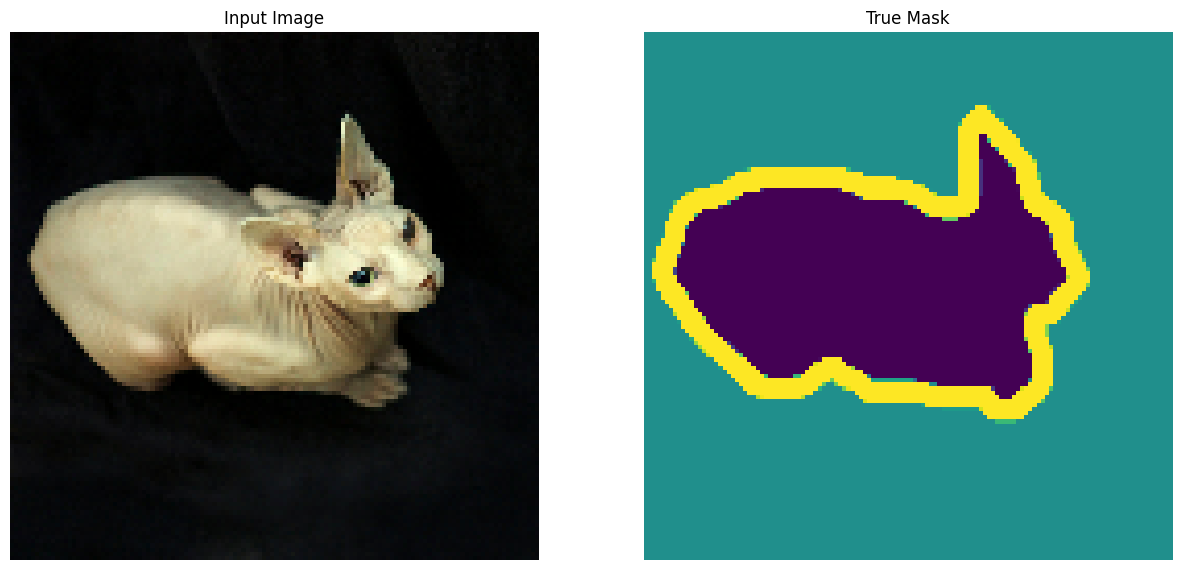

In [ ]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## Definir o modelo
O modelo usado aqui é uma U-Net modificada. Um U-Net consiste em um codificador (downsampler) e decodificador (upsampler). Para aprender características robustas e reduzir o número de parâmetros treináveis, um modelo pré-treinado pode ser usado como codificador. Portanto, o codificador para esta tarefa será um modelo MobileNetV2 pré-treinado, cujas saídas intermediárias serão usadas e o decodificador será o bloco de amostra superior já implementado no TensorFlow Examples no [tutorial Pix2pix] (https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py).

O motivo da saída de três canais é porque existem três rótulos possíveis para cada pixel. Pense nisso como multi-classificação, onde cada pixel está sendo classificado em três classes.

In [ ]:
OUTPUT_CHANNELS = 3

Como mencionado, o codificador será um modelo MobileNetV2 pré-treinado, preparado e pronto para uso em [tf.keras.applications] (https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications). O codificador consiste em saídas específicas de camadas intermediárias no modelo. Observe que o codificador não será treinado durante o processo de treinamento.

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use as ativações dessas camadas
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Crie o modelo de extração de características
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


O decodificador/upsampler é simplesmente uma série de blocos de upsample implementados nos exemplos do TensorFlow.

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):

  # Esta é a última camada do modelo
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling através do modelo
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling e estabelecimento das conexões de salto
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## Treine o modelo
Agora, tudo o que resta a fazer é compilar e treinar o modelo. A perda que está sendo usada aqui é loss.sparse_categorical_crossentropy. O motivo para usar essa função de perda é porque a rede está tentando atribuir a cada pixel um rótulo, assim como a previsão de várias classes. Na verdadeira máscara de segmentação, cada pixel tem um {0,1,2}. A rede aqui está emitindo três canais. Essencialmente, cada canal está tentando aprender a prever uma classe, e loss.sparse_categorical_crossentropy é a perda recomendada para esse cenário. Usando a saída da rede, o rótulo atribuído ao pixel é o canal com o valor mais alto. É isso que a função create_mask está fazendo.

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Dê uma olhada rápida na arquitetura do modelo resultante:

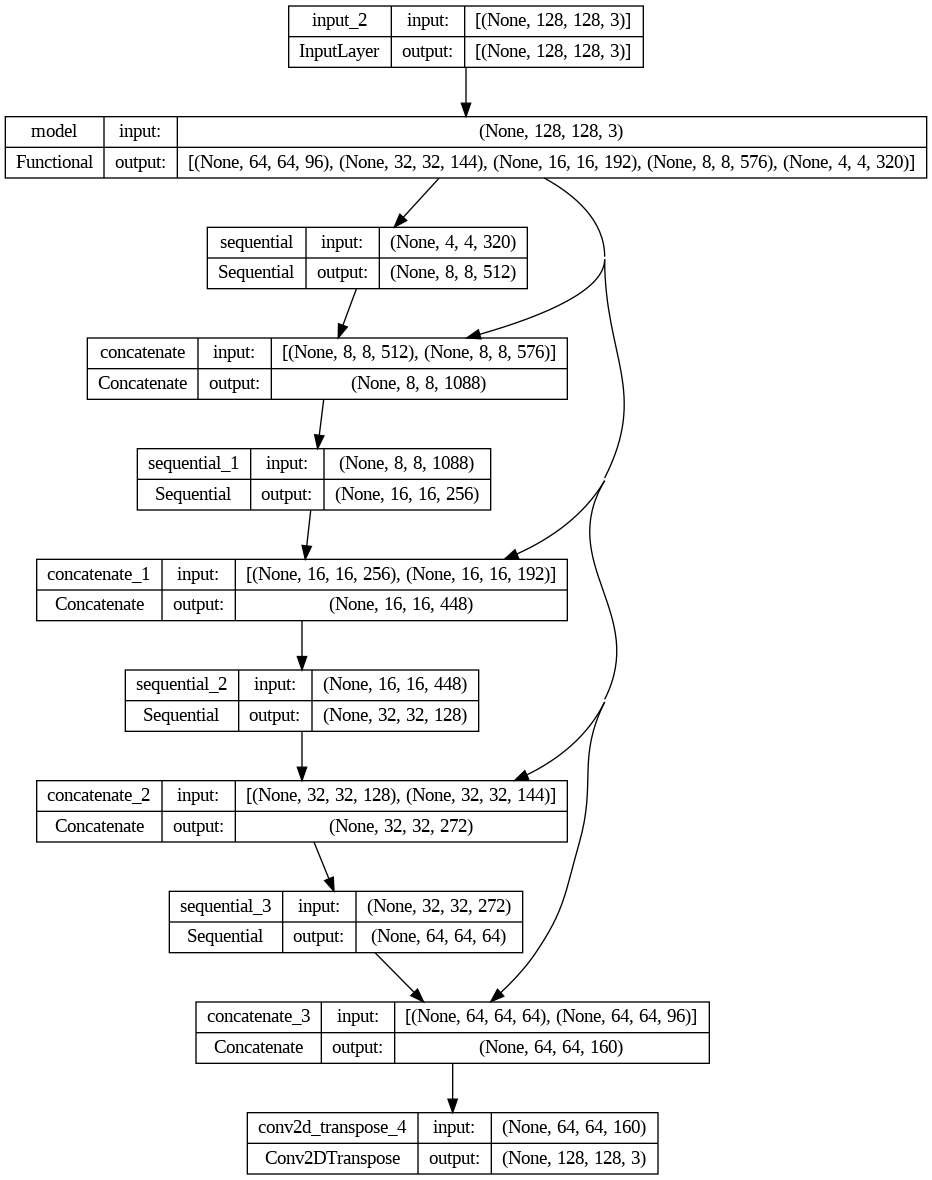

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

Vamos experimentar o modelo para ver o que ele prevê antes do treinamento.

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 9s 9s/step


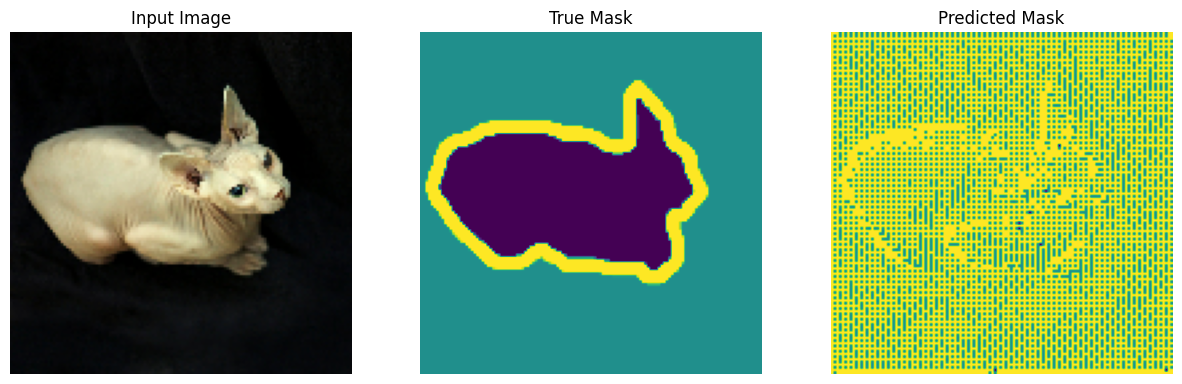

In [ ]:
show_predictions()

Vamos observar como o modelo melhora enquanto está treinando. Para realizar essa tarefa, uma função de retorno de chamada é definida abaixo.

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 24ms/step


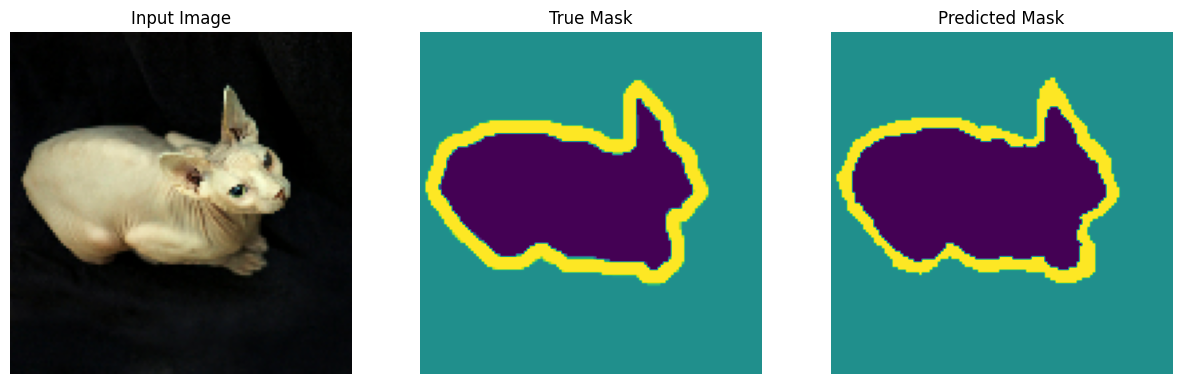


Sample Prediction after epoch 2

57/57 [==============================] - 12s 221ms/step - loss: 0.1532 - accuracy: 0.9311 - val_loss: 0.3185 - val_accuracy: 0.8905


In [ ]:
EPOCHS = 2
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

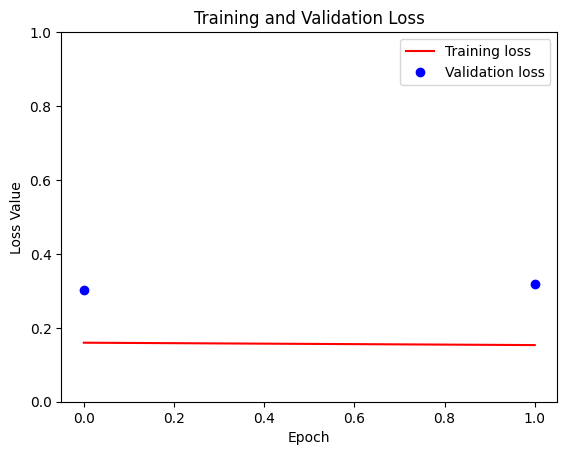

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Fazer Previsões

Vamos fazer algumas previsões. Com o objetivo de economizar tempo, o número de épocas foi pequeno, mas você pode definir isso mais alto para obter resultados mais precisos.

2/2 [==============================] - 0s 52ms/step


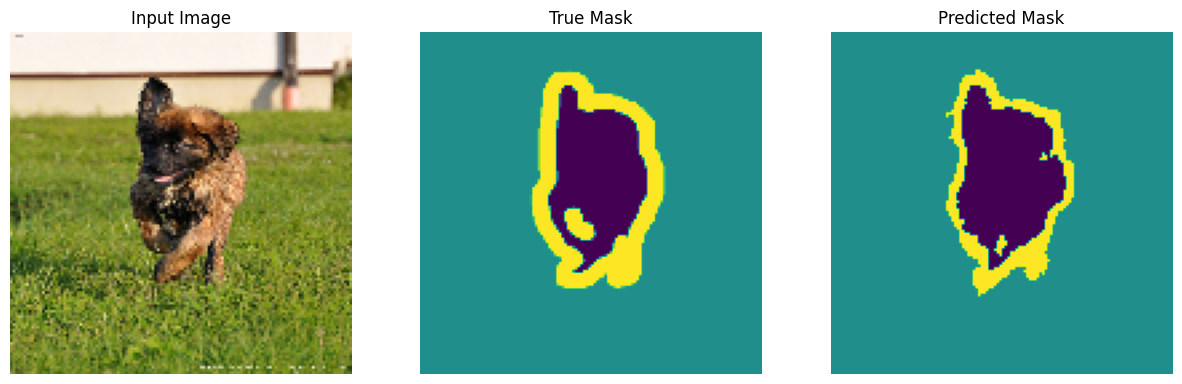

2/2 [==============================] - 0s 46ms/step


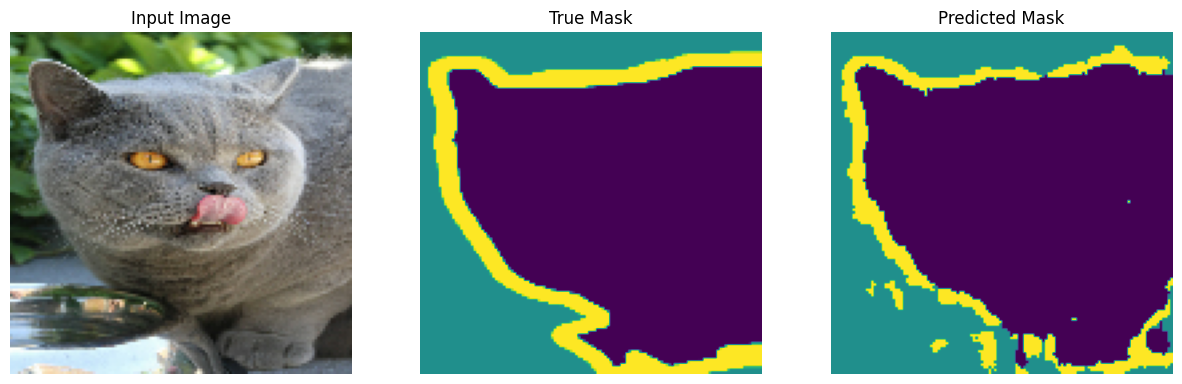

2/2 [==============================] - 0s 47ms/step


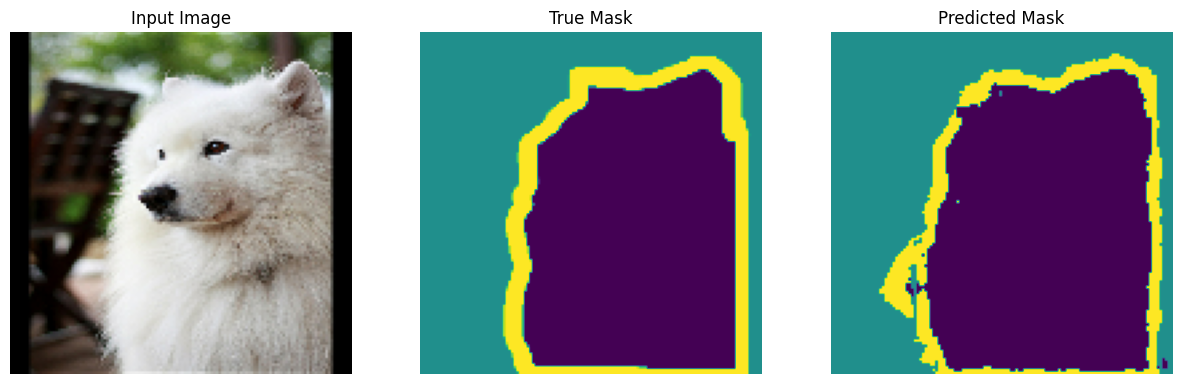

In [ ]:
show_predictions(test_dataset, 3)